# Exploratory Data Analysis for Open Food Facts

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from src.config import Config

In [2]:
spark = SparkSession.builder \
    .appName("OpenFoodFactsEDA") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/17 19:27:32 WARN Utils: Your hostname, AlekseenkoYV, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/06/17 19:27:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/17 19:27:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
config = Config()

In [4]:
df = spark.read.csv(config.raw_data_path, sep="\t", header=True, inferSchema=True).limit(100000)

In [5]:
print(f"Количество строк: {df.count()}")
print(f"Количество колонок: {len(df.columns)}")
df.printSchema()

Количество строк: 100000
Количество колонок: 209
root
 |-- code: double (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: integer (nullable = true)
 |-- created_datetime: timestamp (nullable = true)
 |-- last_modified_t: integer (nullable = true)
 |-- last_modified_datetime: timestamp (nullable = true)
 |-- last_modified_by: string (nullable = true)
 |-- last_updated_t: integer (nullable = true)
 |-- last_updated_datetime: timestamp (nullable = true)
 |-- product_name: string (nullable = true)
 |-- abbreviated_product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- packaging_en: string (nullable = true)
 |-- packaging_text: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- brands_en: string (nullable = true)
 |--

In [6]:
numeric_stats = df.select(config.numeric_columns).describe().toPandas()
numeric_stats

25/06/14 23:12:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g
0,count,80954,80177,80527,76208,80239,72357,72357,59979
1,mean,1440.0120600854048,16.789344071103805,41.63718930756527,19.406514683762683,10.097642445112166,2.3274440992363066,0.9309780908687395,4.04810556725769
2,stddev,2601.357262118162,51.07845431467423,76.77312940678007,43.730341867399716,31.837026602997657,46.40126566303968,18.556642036383465,49.34279740745987
3,min,0.0,0.0,0.0,-1.45,0.0,0.0,0.0,0.0
4,max,238488.0,4444.0,6800.0,1500.0,3500.0,5075.0,2030.0,11800.0


In [7]:
pdf = df.select(config.numeric_columns).sample(0.1).toPandas()

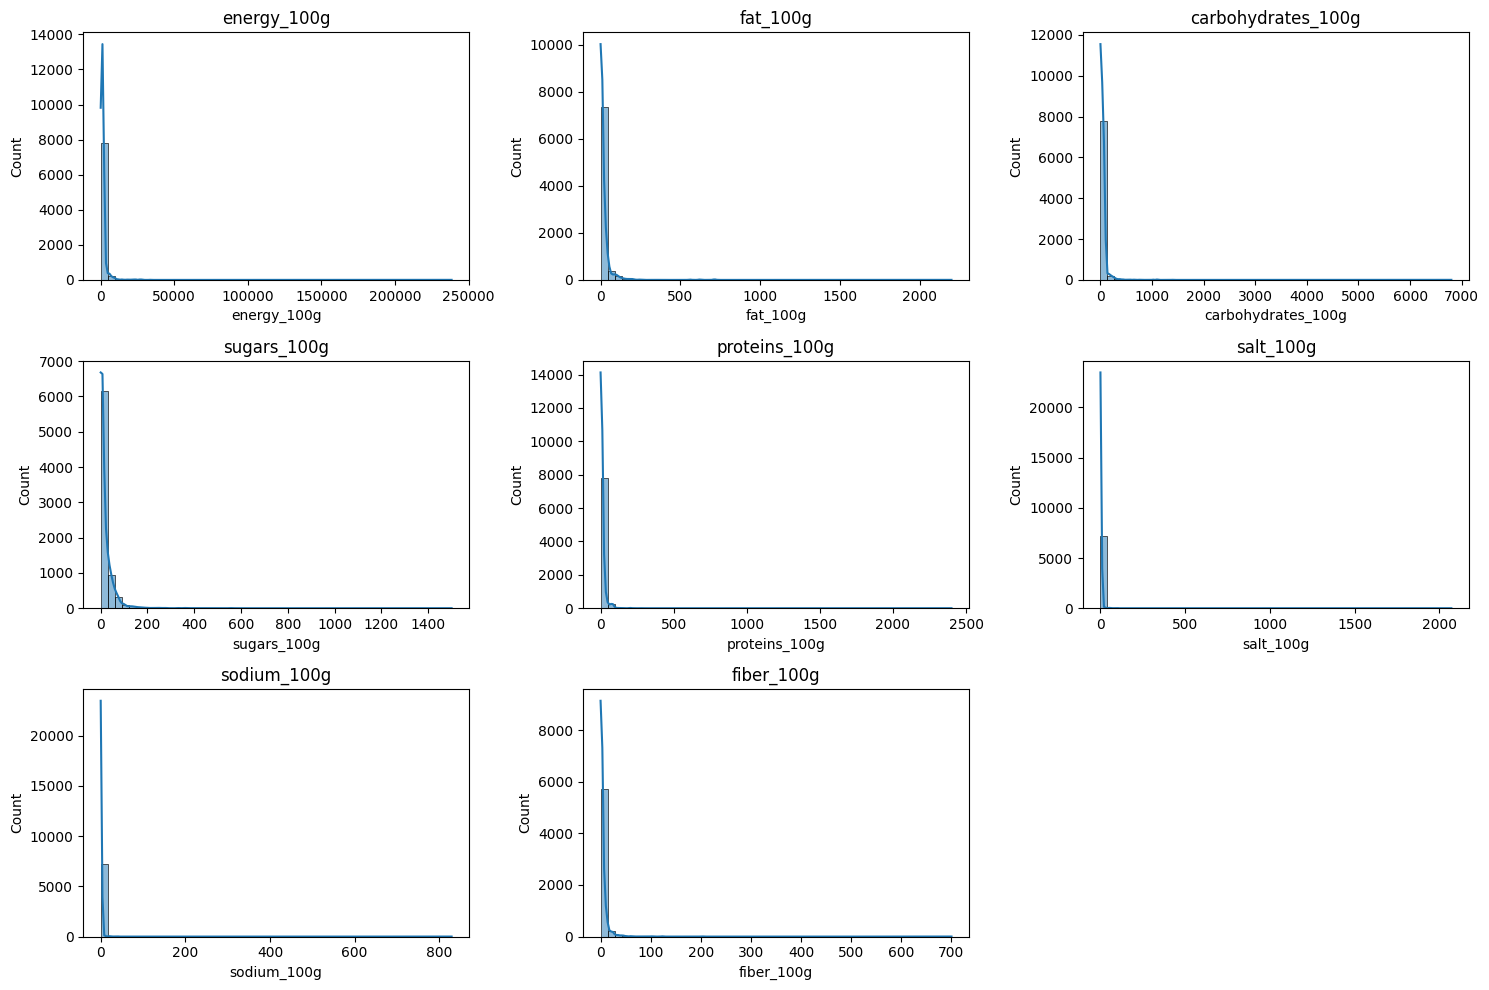

In [8]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(config.numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(pdf[col].dropna(), bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

In [9]:
missing_data = {}
for col in config.numeric_columns:
    missing_count = df.filter(df[col].isNull()).count()
    missing_data[col] = missing_count

In [10]:
missing_df = pd.DataFrame.from_dict(missing_data, orient='index', columns=['missing_count'])
missing_df['missing_percentage'] = (missing_df['missing_count'] / df.count()) * 100
missing_df.sort_values('missing_percentage', ascending=False)

,missing_count,missing_percentage
fiber_100g,40021,40.021
salt_100g,27643,27.643
sodium_100g,27643,27.643
sugars_100g,23792,23.792
fat_100g,19823,19.823
proteins_100g,19761,19.761
carbohydrates_100g,19473,19.473
energy_100g,19046,19.046


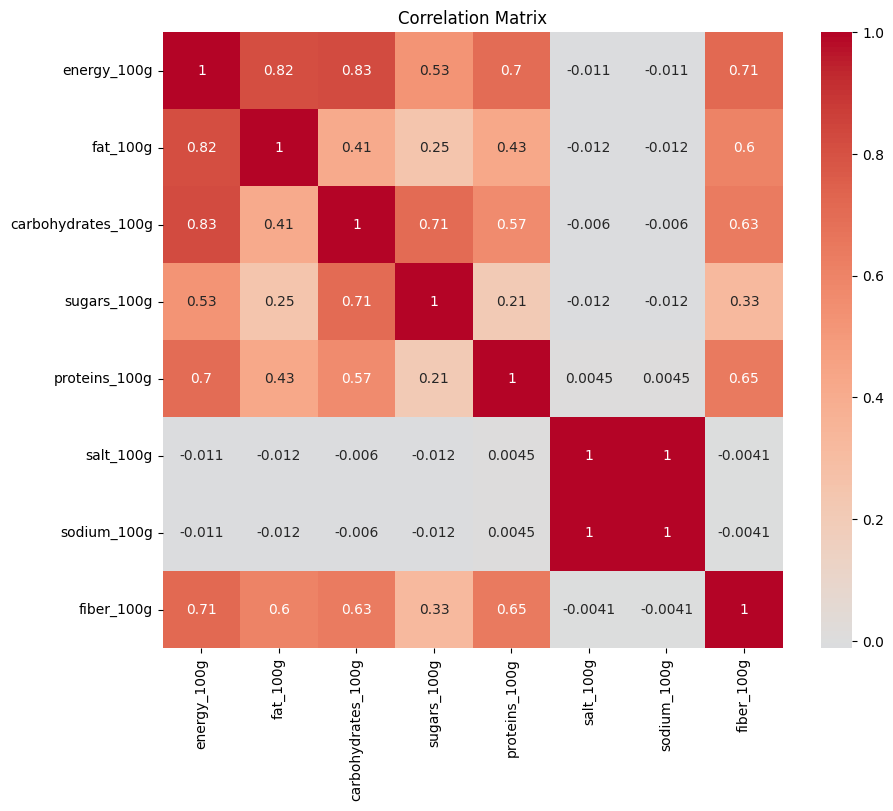

In [11]:
corr_matrix = pdf.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

In [5]:
def product_name_word_count(spark, df):
    product_names = df.select("product_name").na.drop()

    word_counts = product_names.rdd \
        .flatMap(lambda row: row["product_name"].lower().split() if row["product_name"] else []) \
        .map(lambda word: (word, 1)) \
        .reduceByKey(lambda a, b: a + b) \
        .sortBy(lambda x: x[1], ascending=False)
    
    top_words = word_counts.take(20)
    
    print("Топ-20 слов в названиях продуктов:")
    for word, count in top_words:
        print(f"{word}: {count}")

    pd_df = pd.DataFrame(top_words, columns=["word", "count"])
    pd_df.plot.bar(x="word", y="count", figsize=(12, 6), title="Частота слов в названиях продуктов")
    plt.xticks(rotation=45)
    plt.show()

Топ-20 слов в названиях продуктов:
&: 6510
chocolate: 4347
cheese: 4222
with: 3548
organic: 2847
sauce: 2745
chicken: 2634
cream: 2469
de: 2316
and: 2259
mix: 2174
milk: 2020
white: 1936
butter: 1887
sweet: 1881
cheddar: 1654
beef: 1649
style: 1648
fruit: 1643
ice: 1566


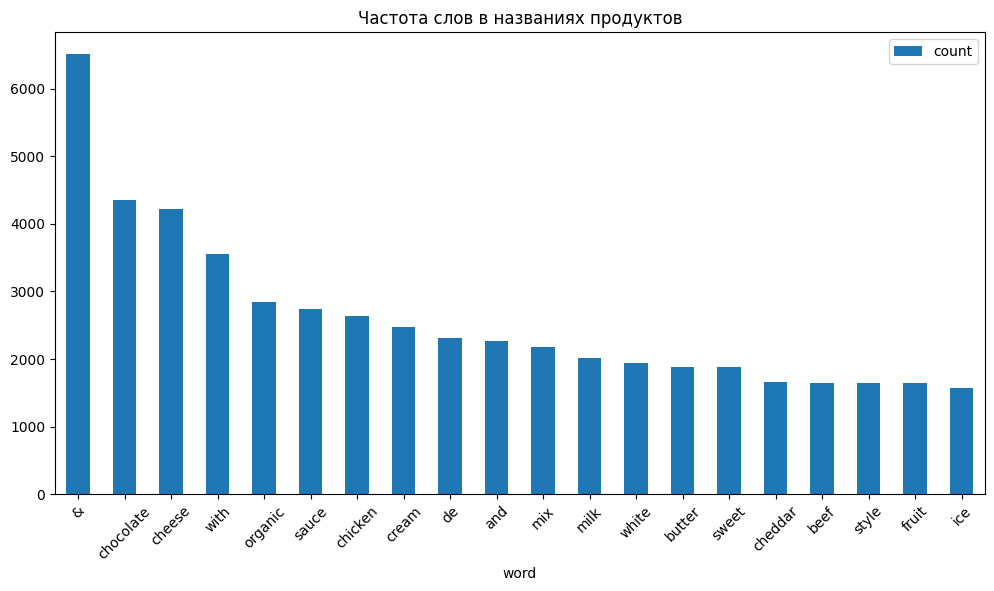

In [6]:
product_name_word_count(spark, df)

In [7]:
spark.stop()